In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import cv2

Using TensorFlow backend.


In [2]:
#Define path to the daa directory
data_dir = Path('./dataset/chest_xray/chest_xray')
# Path to test directory
test_dir = data_dir / 'test'

In [3]:
import glob3 as glob
def data_path(Dir):
    # Get the path to the normal and pneumonia sub-directories
    normal_cases_dir = Dir / 'NORMAL'
    pneumonia_cases_dir = Dir / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data = pd.DataFrame(data, columns=['image', 'label'],index=None)

    # Shuffle the data 
    data = data.sample(frac=1.).reset_index(drop=True)

    return data

In [4]:
test_data_info = data_path(test_dir)
test_data_info.head()

,image,label
0,dataset\chest_xray\chest_xray\test\NORMAL\IM-0...,0
1,dataset\chest_xray\chest_xray\test\NORMAL\NORM...,0
2,dataset\chest_xray\chest_xray\test\NORMAL\NORM...,0
3,dataset\chest_xray\chest_xray\test\PNEUMONIA\p...,1
4,dataset\chest_xray\chest_xray\test\PNEUMONIA\p...,1


In [5]:
def preparing_test_data(data):
    
    x = []
    y = []
    pneumonia_cases = (data[data['label']==1]['image'].iloc[:])
    normal_cases = (data[data['label']==0]['image'].iloc[:])
    
    # Normal cases
    for img in normal_cases:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        label = to_categorical(0, num_classes=2)
        x.append(img)
        y.append(label)

    # Pneumonia cases        
    for img in pneumonia_cases:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        label = to_categorical(1, num_classes=2)
        x.append(img)
        y.append(label)

    # Convert the list into numpy arrays
    x = np.array(x)
    y = np.array(y)

    
    return x, y

In [6]:
test_data ,test_label =preparing_test_data(test_data_info)
print(test_data.shape)
print(test_label.shape)

(624, 224, 224, 3)
(624, 2)


In [16]:
from model.model_codiv19 import build_model
model = build_model()
model.summary()
# Load the model weights
model.load_weights("./models/best_model")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [17]:
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

optimizer = Adam(lr=0.0001 , decay=1e-5)
es = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath = 'best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(optimizer=optimizer ,loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_label, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 37s 59ms/step
Loss on test set:  0.4203973997097749
Accuracy on test set:  0.8317307829856873


In [19]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_label = np.argmax(test_label, axis=-1)

print(orig_test_label.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

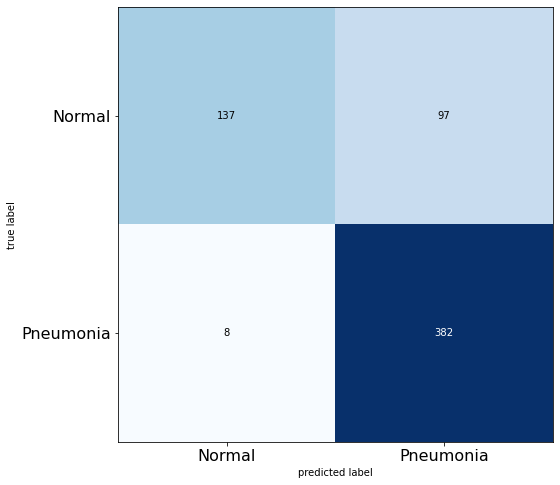

In [20]:
cm  = confusion_matrix(orig_test_label, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()